# 1. Preparing our dataset

¡Estas recomendaciones son tan acertadas! ¿Cómo me conoce tan bien esta lista de reproducción?

En los últimos años, los servicios de streaming con grandes catálogos se han convertido en el principal medio a través del cual la mayoría de la gente escucha su música favorita. Pero al mismo tiempo, la gran cantidad de música que se ofrece puede significar que los usuarios pueden estar un poco abrumados al tratar de buscar música más reciente que se adapte a sus gustos.

Por esta razón, los servicios de streaming han buscado formas de categorizar la música para permitir recomendaciones personalizadas. Un método implica el análisis directo de la información de audio cruda en una canción dada, anotando los datos crudos en una variedad de métricas. Hoy, examinaremos los datos recopilados por un grupo de investigación conocido como The Echo Nest. Nuestro objetivo es mirar a través de este conjunto de datos y clasificar las canciones como 'Hip-Hop' o 'Rock' - todo sin escuchar a uno solo nosotros mismos.Al hacerlo, aprenderemos cómo limpiar nuestros datos, hacer alguna visualización exploratoria de datos, y utilizar la reducción de funciones hacia el objetivo de alimentar nuestros datos a través de algunos algoritmos simples de aprendizaje automático, como árboles de decisión y regresión logística.

Para empezar, vamos a cargar los metadatos sobre nuestras pistas junto con las métricas de pistas compiladas por The Echo Nest. Una canción es más que su título, artista y número de escuchas. Tenemos otro conjunto de datos que tiene características musicales de cada pista como la bailabilidad y la acústica en una escala de -1 a 1. Estos existen en dos archivos diferentes, que están en diferentes formatos - CSV y JSON. Mientras que CSV es un formato de archivo popular para denotar datos tabulares, JSON es otro formato de archivo común en el que las bases de datos suelen devolver los resultados de una consulta determinada.

Vamos a empezar creando dos pandas DataFrames de estos archivos que podemos fusionar para que tengamos características y etiquetas (a menudo también conocidas como X e y) para la clasificación más adelante.



In [1]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('Data/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('Data/echonest-metrics.json', precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['genre_top', 'track_id']], on='track_id')

# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


# 2. Pairwise relationships between continuous variables

Normalmente queremos evitar el uso de variables que tienen fuertes correlaciones entre sí -- evitando así la redundancia de características -- por algunas razones:
* Para mantener el modelo simple y mejorar la interpretabilidad (con muchas características, corremos el riesgo de sobreadaptación). 
* Cuando nuestros conjuntos de datos son muy grandes, usar menos características puede acelerar drásticamente nuestro tiempo de cálculo.

Para tener una idea de si hay alguna característica fuertemente correlacionada en nuestros datos, usaremos funciones incorporadas en el paquete pandas.

In [15]:
# Create a correlation matrix
corr_metrics = echonest_metrics.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.279829,0.102056,0.121991,-0.283206,-0.004059,-0.075077,0.004313,0.020201
acousticness,-0.279829,1.000000,-0.189599,-0.477273,0.110033,0.041319,0.038785,-0.110701,-0.085436
danceability,0.102056,-0.189599,1.000000,0.045345,-0.118033,-0.143339,0.171311,-0.094352,0.428515
energy,0.121991,-0.477273,0.045345,1.000000,-0.002412,0.045752,-0.008645,0.227324,0.219384
instrumentalness,-0.283206,0.110033,-0.118033,-0.002412,1.000000,-0.058593,-0.216689,0.023003,-0.145200
liveness,-0.004059,0.041319,-0.143339,0.045752,-0.058593,1.000000,0.073104,-0.007566,-0.017886
speechiness,-0.075077,0.038785,0.171311,-0.008645,-0.216689,0.073104,1.000000,0.032188,0.094794
tempo,0.004313,-0.110701,-0.094352,0.227324,0.023003,-0.007566,0.032188,1.000000,0.129911
valence,0.020201,-0.085436,0.428515,0.219384,-0.145200,-0.017886,0.094794,0.129911,1.000000


# 3. Normalizing the feature data
Como se mencionó anteriormente, puede ser particularmente útil simplificar nuestros modelos y utilizar las pocas características que sean necesarias para lograr el mejor resultado. Dado que no encontramos ninguna correlación fuerte entre nuestras características, podemos utilizar un enfoque común para reducir el número de características llamadas análisis de componentes principales (PCA). 

Es posible que la variación entre géneros se pueda explicar por sólo unas pocas características en el conjunto de datos. PCA rota los datos a lo largo del eje de mayor varianza, lo que nos permite determinar la contribución relativa de cada característica de nuestros datos hacia la varianza entre clases.

Sin embargo, dado que PCA utiliza la varianza absoluta de una característica para rotar los datos, una característica con un rango más amplio de valores dominará y sesgará el algoritmo en relación con las otras características. Para evitar esto, primero debemos normalizar nuestros datos. Hay algunos métodos para hacer esto, pero una manera común es a través de la estandarización, de tal manera que todas las características tienen una media = 0 y desviación estándar = 1 (el resultado es un z-score).

In [7]:
# Define our features
features = echo_tracks.drop(columns=['genre_top', 'track_id']) 

# Define our labels
labels = echo_tracks['genre_top']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

# 4. Principal Component Analysis on our scaled data
Ahora que hemos preprocesado nuestros datos, estamos listos para utilizar PCA para determinar por cuánto podemos reducir la dimensionalidad de nuestros datos. Podemos utilizar parcelas de scree y parcelas de razón explicadas acumulativas para encontrar el número de componentes a utilizar en análisis adicionales.

Los diagramas de scree muestran el número de componentes contra la varianza explicada por cada componente, ordenados en orden descendente de varianza. Las parcelas de scree nos ayudan a tener una mejor idea de qué componentes explican una cantidad suficiente de varianza en nuestros datos. Cuando se utilizan parcelas scree, un 'codo' (una caída pronunciada de un punto de datos al siguiente) en la parcela se utiliza típicamente para decidir sobre un corte apropiado.

Text(0.5, 0, 'Principal Component #')

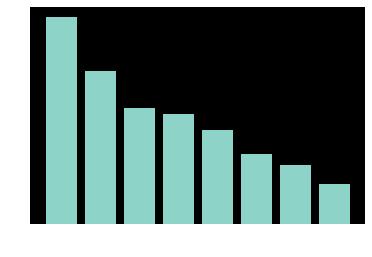

In [14]:
# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.style.use("dark_background")

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

# 5. Further visualization of PCA
Desafortunadamente, no parece haber un codo claro en esta trama scree, lo que significa que no es fácil encontrar el número de dimensiones intrínsecas utilizando este método.

¡Pero no todo está perdido! En su lugar, también podemos mirar la gráfica de varianza explicada acumulativa para determinar cuántas características se requieren para explicar, digamos, alrededor del 85% de la varianza (los cortes son algo arbitrarios aquí, y generalmente se deciden por 'reglas de oro'). Una vez que determinamos el número apropiado de componentes, podemos realizar PCA con muchos componentes, lo ideal es reducir la dimensionalidad de nuestros datos.


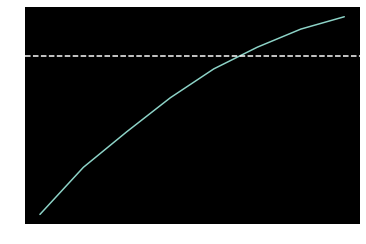

In [16]:
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

# choose the n_components where about 85% of our variance can be explained
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

# 6. Train a decision tree to classify genre
Ahora podemos usar la proyección PCA de menor dimensión de los datos para clasificar las canciones en géneros. Para ello, primero necesitamos dividir nuestro conjunto de datos en subconjuntos 'tren' y 'prueba', donde el subconjunto 'tren' se utilizará para entrenar nuestro modelo, mientras que el conjunto de datos 'prueba' permite la validación del rendimiento del modelo.

Aquí, usaremos un algoritmo simple conocido como árbol de decisiones. Los árboles de decisión son clasificadores basados en reglas que toman en características y siguen una 'estructura de árbol' de decisiones binarias para finalmente clasificar un punto de datos en una de dos o más categorías. Además de ser fáciles de usar e interpretar, los árboles de decisión nos permiten visualizar el 'diagrama de flujo lógico' que el modelo genera a partir de los datos de entrenamiento.

Aquí hay un ejemplo de un árbol de decisiones que demuestra el proceso por el cual una imagen de entrada (en este caso, de una forma) podría clasificarse en función del número de lados que tiene y si se gira.
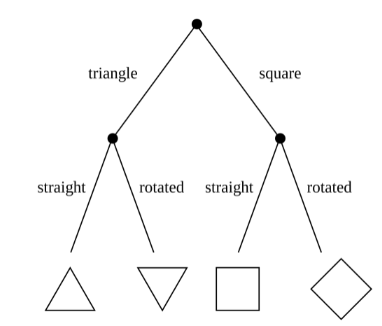

In [17]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

# 7. Compare our decision tree to a logistic regression
Aunque el rendimiento de nuestro árbol es decente, es una mala idea asumir inmediatamente que es por lo tanto la herramienta perfecta para este trabajo -- ¡siempre existe la posibilidad de que otros modelos funcionen aún mejor! Siempre vale la pena probar otros algoritmos y encontrar el que mejor se adapte a nuestros datos.

A veces lo más simple es lo mejor, y así empezaremos aplicando regresión logística. La regresión logística hace uso de lo que se llama la función logística para calcular las probabilidades de que un punto de datos determinado pertenece a una clase determinada. Una vez que tenemos ambos modelos, podemos compararlos en unas pocas métricas de rendimiento, como la tasa de falsos positivos y falsos negativos (o cuántos puntos están clasificados incorrectamente).

In [18]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logisitic regression
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



# 8. Balance our data for greater performance
Ambos modelos tienen un rendimiento similar, con una precisión media del 87% cada uno. Sin embargo, mirando nuestro informe de clasificación, podemos ver que las canciones de rock están bastante bien clasificadas, pero las canciones de hip-hop están desproporcionadamente clasificadas como canciones de rock.

¿Por qué podría ser este el caso? Bueno, con sólo mirar el número de puntos de datos que tenemos para cada clase, vemos que tenemos muchos más puntos de datos para la clasificación de rocas que para el hip-hop, potencialmente sesgada la capacidad de nuestro modelo para distinguir entre clases. Esto también nos dice que la mayor parte de la precisión de nuestro modelo es impulsada por su capacidad para clasificar sólo canciones de rock, que es menos que ideal.

Para tener en cuenta esto, podemos ponderar el valor de una clasificación correcta en cada clase inversamente a la ocurrencia de puntos de datos para cada clase. Puesto que una clasificación correcta para "Rock" no es más importante que una clasificación correcta para "Hip-Hop" (y viceversa), sólo tenemos que tener en cuenta las diferencias en el tamaño de la muestra de nuestros puntos de datos al ponderar nuestras clases aquí, y no la importancia relativa de cada clase.

In [19]:
# Subset a balanced proportion of data points
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# subset only the rock songs, and take a sample the same size as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# concatenate the dataframes hop_only and rock_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)

# 9. Does balancing our dataset improve model bias?
Ahora hemos equilibrado nuestro conjunto de datos, pero al hacerlo, hemos eliminado muchos puntos de datos que podrían haber sido cruciales para entrenar a nuestros modelos. Vamos a probar para ver si el equilibrio de nuestros datos mejora el sesgo del modelo hacia la clasificación "Rock", manteniendo al mismo tiempo el rendimiento general de la clasificación.

Tenga en cuenta que ya hemos reducido el tamaño de nuestro conjunto de datos y avanzaremos sin aplicar ninguna reducción de dimensionalidad. En la práctica, consideraríamos la reducción de la dimensionalidad más rigurosamente cuando se trata de conjuntos de datos muy grandes y cuando los tiempos de cálculo se vuelven prohibitivamente grandes.

In [20]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.73      0.74       230
        Rock       0.73      0.74      0.73       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.80      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



# 10. Using cross-validation to evaluate our models
¡Éxito! Equilibrar nuestros datos ha eliminado el sesgo hacia la clase más prevalente. Para tener una buena idea de lo bien que están funcionando nuestros modelos, podemos aplicar lo que se llama validación cruzada (CV). Este paso nos permite comparar modelos de una manera más rigurosa.

Dado que la forma en que nuestros datos se dividen en trenes y conjuntos de pruebas puede afectar el rendimiento del modelo, CV intenta dividir los datos de varias maneras y probar el modelo en cada una de las divisiones. Aunque hay muchos métodos diferentes de CV, todos con sus propias ventajas y desventajas, vamos a utilizar lo que se conoce como K-fold CV aquí. K-fold primero divide los datos en K subconjuntos diferentes, de igual tamaño.Luego, utiliza iterativamente cada subconjunto como un conjunto de pruebas mientras usa el resto de los datos como conjuntos de trenes. Finalmente, podemos agregar los resultados de cada pliegue para una puntuación final de rendimiento del modelo.

In [21]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)

# Print the mean of each array o scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7489010989010989 Logistic Regression: 0.782967032967033
